# Análise de um Sistema representado no Espaçode Estado com equações recursivas na forma expandida

In [1]:
import numpy as np
import control
import control.matlab
import matplotlib.pyplot as plt

In [2]:
# Matrizes do Sistema
A = np.matrix('0 1 0;0 0 1;-1 -5 -6')
B = np.matrix('0;0;1')
C = np.matrix('1 1 1')
D = 0
sistema = control.ss(A,B,C,D)
#  Condições Iniciais
x0 = np.matrix('1; 1; 1')

In [3]:
# entrada nula - u
t = np.linspace(0, 30, 1000)
u = np.zeros(len(t))


In [4]:
# resposta para entrada nula
Y, t, X = control.matlab.lsim(sistema,u,t,x0)
# separando os elemntos do vetor X
x1a = X[:,0]
x1b = X[:,1]
x1c = X[:,2]

In [5]:
# simulação com discretização dos integradores
# I(z)=T/(z-1)=Xi(z)/Xi_ponto(z)
# xi(k)=T*xi_ponto(k-1)+xi(k-1)


In [6]:
t = np.linspace(0, 30, 1000)
T = 1
tfinal = 30
Kmax = int(tfinal/T+1)
K = np.linspace(0, Kmax, Kmax+1)
u = np.zeros(len(K))

# System
A = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [-1, -5, -6]
])
B = np.array([0, 0, 1])
C = np.array([1, 1, 1])
D = np.array([0, 0, 0])

# Signals
x = np.zeros((len(K), 3))
xdot = np.zeros((len(K), 3))
y = np.zeros((len(K), 3))

# Initial
x0 = np.array([1, 1, 1])
x[0] = x0

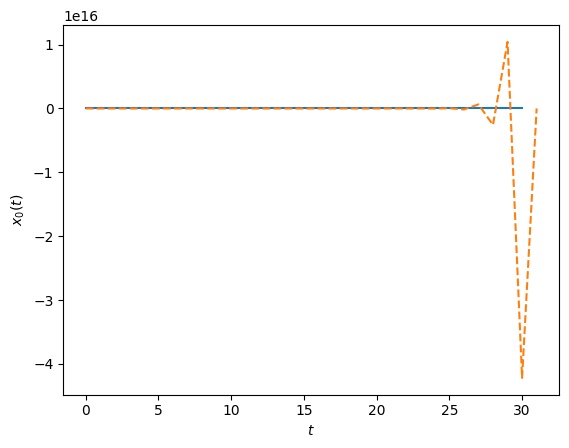

In [7]:
for k in range(0, Kmax -1):
    # Euler Integrator
    x[k+1] = T*xdot[k] + x[k]

    # States equation
    xdot[k+1] = np.dot(A, x[k+1]) + np.dot(B, u[k+1])

    # Outputs equation
    y[k+1] = np.dot(C, x[k+1]) + np.dot(D, u[k+1])

plt.figure()
plt.plot(t, x1a)
plt.plot(K*T, x[:,0], '--')
plt.xlabel("$t$")
plt.ylabel("$x_{0}(t)$")
plt.show()

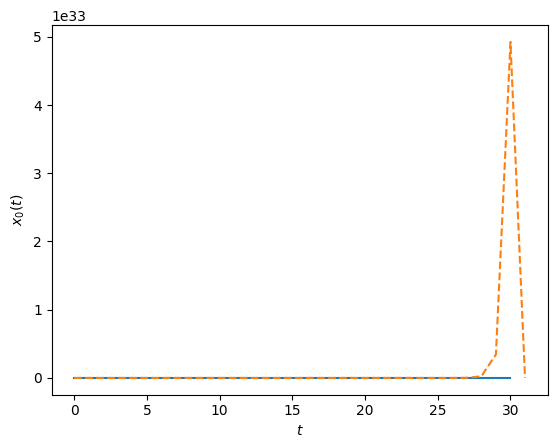

In [8]:
for k in range(0, Kmax -1):
    # Runge-Kutta integration
    k1 = T * (np.dot(A, x[k]) + np.dot(B, u[k]))
    k2 = T * (np.dot(A, x[k] + 0.5*k1) + np.dot(B, u[k]))
    k3 = T * (np.dot(A, x[k] + 0.5*k2) + np.dot(B, u[k]))
    k4 = T * (np.dot(A, x[k] + k3) + np.dot(B, u[k]))
    x[k+1] = x[k] + (1/6) * (k1 + 2*k2 + 2*k3 + k4)

    # States equation
    xdot[k+1] = np.dot(A, x[k+1]) + np.dot(B, u[k+1])

    # Outputs equation
    y[k+1] = np.dot(C, x[k+1]) + np.dot(D, u[k+1])

plt.figure()
plt.plot(t, x1a)
plt.plot(K*T, x[:,0], '--')
plt.xlabel("$t$")
plt.ylabel("$x_{0}(t)$")
plt.show()


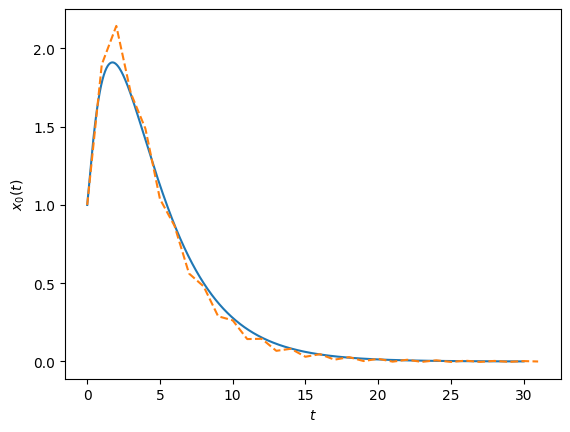

In [9]:
from scipy.optimize import fsolve


def radau_residual(x_new, x_prev, k, A, B, u, T):
    return x_new - x_prev - T * (1/3 * np.dot(A, x_new) + 2/3 * np.dot(A, x_prev) + 2/3 * np.dot(B, u[k]))

for k in range(0, Kmax - 1):
    # Radau IIA implicit Runge-Kutta integration
    initial_guess = x[k] + T * np.dot(A, x[k]) + T * np.dot(B, u[k])

    x[k+1] = fsolve(radau_residual, initial_guess, args=(x[k], k, A, B, u, T))

    # States equation
    xdot[k+1] = np.dot(A, x[k+1]) + np.dot(B, u[k+1])

    # Outputs equation
    y[k+1] = np.dot(C, x[k+1]) + np.dot(D, u[k+1])

plt.figure()
plt.plot(t, x1a)
plt.plot(K*T, x[:,0], '--')
plt.xlabel("$t$")
plt.ylabel("$x_{0}(t)$")
plt.show()

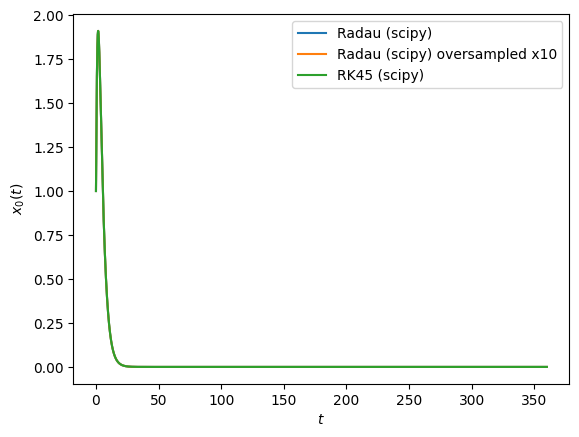

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# State Transition matrix, shape 'n_states,n_states'
A = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [-1, -5, -6]
])
# Input matrix, shape 'n_states,n_inputs'
B = np.array([
    [0],
    [0],
    [1]
])
# Output matrix, shape 'n_outputs,n_states'
C = np.array([
    [1, 1, 1]
])
# Remaining matrix, shape 'n_outputs,n_inputs'
D = np.array([
    [0]
])

# Time and Inputs
tfinal = 360
T = 0.001
t = np.linspace(0, tfinal, int((tfinal) / T) +1)
outputs = 1
inputs = 1
u = np.zeros(shape=(len(t), inputs))

# Initial condition
x0 = np.array([1, 1, 1])

def simulate(x0, t, u, sys, method='Radau', oversampling_factor=1):
    # Create a new time vector for the oversampled signal
    t = np.linspace(0, t[-1], (len(t)*oversampling_factor) + 1)[:-1]

    # Oversample
    u = np.repeat(u, oversampling_factor)

    # Get the system
    A, B, C, D = sys
    (n_states, n_inputs) = B.shape
    n_outputs = D.shape[0]

    # Create Signals
    kmax = len(t)
    T = t[1] - t[0]
    y = np.zeros((kmax, n_outputs))
    u = u.reshape((kmax, n_inputs))

    # Ensure correct shapes
    assert(x0.shape[0] == n_states)
    assert(A.shape == (n_states, n_states))
    assert(B.shape == (n_states, n_inputs))
    assert(C.shape == (n_outputs, n_states))
    assert(D.shape == (n_outputs, n_inputs))
    assert(y.shape[1] == n_outputs)
    assert(u.shape[1] == n_inputs)
    assert(y.shape[0] == kmax)
    assert(u.shape[0] == kmax)

    def system(t, x):
        k = int(t / T)

        # States equation
        xdot = np.add(np.dot(A, x), np.dot(B, u[k]))

        # Outputs equation
        y[k] = np.add(np.dot(C, x), np.dot(D, u[k]))

        return xdot

    x = solve_ivp(system, (t[0], t[-1]), x0, method=method, t_eval=t).y.T

    # Downsample
    y = y[:][::oversampling_factor]
    x = x[:][::oversampling_factor]
    t = t[:][::oversampling_factor]

    return t, x, y

In [36]:
import control as ct

class System:
    @classmethod
    def _update(cls, t, x, u, params: dict):
        return np.add(np.dot(params["A"], x), np.dot(params["B"], u))

    @classmethod
    def _output(cls, t, x, u, params: dict):
        return np.add(np.dot(params["C"], x), np.dot(params["D"], u))

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._output,
            name="system",
            states=("x0", "x1", "x2"),
            inputs=("u0",),
            outputs=("y0"),
            params=params,
        )

Radau (oversampling=1): 0.0108 seconds, RMSE=0.3965
RK45 (oversampling=1): 0.0203 seconds, RMSE=0.3965
RK23 (oversampling=1): 0.0162 seconds, RMSE=0.3966


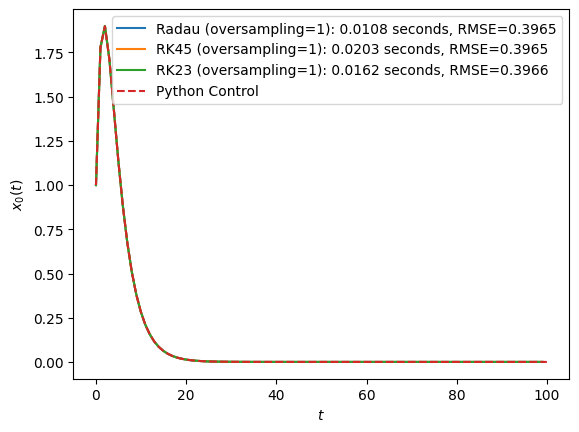

In [39]:
import itertools
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lsim

# State Transition matrix, shape 'n_states,n_states'
A = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [-1, -5, -6]
])
# Input matrix, shape 'n_states,n_inputs'
B = np.array([
    [0],
    [0],
    [1]
])
# Output matrix, shape 'n_outputs,n_states'
C = np.array([
    [1, 1, 1]
])
# Remaining matrix, shape 'n_outputs,n_inputs'
D = np.array([
    [0]
])

# Time and Inputs
tfinal = 100
T = 1
t = np.linspace(0, tfinal, tfinal // T + 1)
outputs = 1
inputs = 1
u = np.zeros(shape=(len(t), inputs))

# Initial condition
x0 = np.array([1, 1, 1])

methods = ['Radau', 'RK45', 'RK23']  # Add other methods as needed
oversampling_factors = [1]  # Add other oversampling factors as needed

plt.figure()

for method, factor in itertools.product(methods, oversampling_factors):
    plt.xlabel("$t$")

    # Simulate using your method
    start_time = time.time()
    res = simulate(x0, t, u, (A, B, C, D), method=method, oversampling_factor=factor)
    end_time = time.time()

    # Simulate using lsim for comparison
    _, lsim_response, _ = lsim((A, B, C, D), u, t)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((res[1][:, 0] - lsim_response)**2))

    # Print results
    label = f'{method} (oversampling={factor}): {end_time - start_time:.4f} seconds, RMSE={rmse:.4f}'
    print(label)

    # Plot the simulated response
    plt.plot(res[0], res[1][:, 0], label=label)

sys = System.build(params={
    'A': A,
    'B': B,
    'C': C,
    'D': D,
})

res = ct.input_output_response(sys, t, U=u.T, X0=x0)
res.output_labels = sys.output_labels
res.input_labels = sys.input_labels
res.state_labels = sys.state_labels
outputs = res.to_pandas().set_index("time")
plt.plot(outputs.index, outputs['x0'], '--', label='Python Control')

plt.ylabel("$x_{0}(t)$")
plt.legend()
plt.show()
